In [1]:
!pip install -q numpy>=2.0 transformers>=4.41 sentence-transformers


In [2]:
!pip install trl \
peft \
accelerate \
datasets \
evaluate \



In [3]:
import torch

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)
    print(f"✅ GPU: {gpu_name}")
    print(f"✅ Total VRAM: {gpu_memory:.2f} GB")
else:
    print("❌ No GPU detected. Please enable GPU runtime.")
    print("Go to: Runtime → Change runtime type → T4 GPU")

✅ GPU: NVIDIA L4
✅ Total VRAM: 22.03 GB


In [4]:
import os
import re
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    GenerationConfig
)
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
from trl import SFTTrainer, SFTConfig
import evaluate

warnings.filterwarnings('ignore')
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

print("✅ All imports loaded successfully!")
print(f"PyTorch version: {torch.__version__}")

✅ All imports loaded successfully!
PyTorch version: 2.10.0+cu128


Dataset Loading and Exploaration

In [5]:
!pip install -q huggingface_hub

from huggingface_hub import hf_hub_download

file_path = hf_hub_download(
    repo_id="Amod/mental_health_counseling_conversations",
    filename="combined_dataset.json",
    repo_type="dataset"
)

print(f"✅ File downloaded to: {file_path}")

✅ File downloaded to: /root/.cache/huggingface/hub/datasets--Amod--mental_health_counseling_conversations/snapshots/d7e86f0813c5690181b41f97403c3674aa55dcef/combined_dataset.json


In [6]:
import json

raw_data_list = []
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        raw_data_list.append(json.loads(line))

raw = raw_data_list

print(f"Type          : {type(raw)}")

if isinstance(raw, list):
    print(f"Total records : {len(raw)}")
    print(f"First record  : {raw[0]}")

elif isinstance(raw, dict):
    print(f"Top-level keys: {list(raw.keys())}")
    for key in raw.keys():
        val = raw[key]
        print(f"\nKey '{key}' — type: {type(val)}, length: {len(val) if hasattr(val, '__len__') else 'N/A'}")
        if isinstance(val, list) and len(val) > 0:
            print(f"  First item: {val[0]}")

Type          : <class 'list'>
Total records : 3512
First record  : {'Context': "I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n   I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.\n   How can I change my feeling of being worthless to everyone?", 'Response': "If everyone thinks you're worthless, then maybe you need to find new people to hang out with.Seriously, the social context in which a person lives is a big influence in self-esteem.Otherwise, you can go round and round trying to understand why you're not worthless, then go back to the same crowd and be knocked down again.There are many inspirational messages you can find in social media. \xa0Maybe read some of the ones which state that no person is worthless, and that everyone has a good purpose to their life.Also, since our culture is so saturated with the belief th

Preview examples

In [7]:
print("=" * 70)
for i in range(3):
    print(f"\n--- Example {i+1} ---")
    print(f"CONTEXT (Patient):\n{raw[i]['Context']}")
    print(f"\nRESPONSE (Counselor):\n{raw[i]['Response'][:300]}...")
    print("=" * 70)


--- Example 1 ---
CONTEXT (Patient):
I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.
   I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.
   How can I change my feeling of being worthless to everyone?

RESPONSE (Counselor):
If everyone thinks you're worthless, then maybe you need to find new people to hang out with.Seriously, the social context in which a person lives is a big influence in self-esteem.Otherwise, you can go round and round trying to understand why you're not worthless, then go back to the same crowd and...

--- Example 2 ---
CONTEXT (Patient):
I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.
   I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.
  

Statistics and null check

In [8]:
df = pd.DataFrame(raw)

print("Null values per column:")
print(df.isnull().sum())

print(f"\nDuplicate rows: {df.duplicated().sum()}")

df['context_word_count'] = df['Context'].apply(lambda x: len(str(x).split()))
df['response_word_count'] = df['Response'].apply(lambda x: len(str(x).split()))

print("\nContext word count stats:")
print(df['context_word_count'].describe())
print("\nResponse word count stats:")
print(df['response_word_count'].describe())

Null values per column:
Context     0
Response    0
dtype: int64

Duplicate rows: 760

Context word count stats:
count    3512.000000
mean       55.180809
std        48.275077
min         5.000000
25%        28.000000
50%        46.000000
75%        68.000000
max       526.000000
Name: context_word_count, dtype: float64

Response word count stats:
count    3512.000000
mean      177.001993
std       120.744872
min         0.000000
25%        93.000000
50%       144.000000
75%       221.000000
max       939.000000
Name: response_word_count, dtype: float64


Visualisation

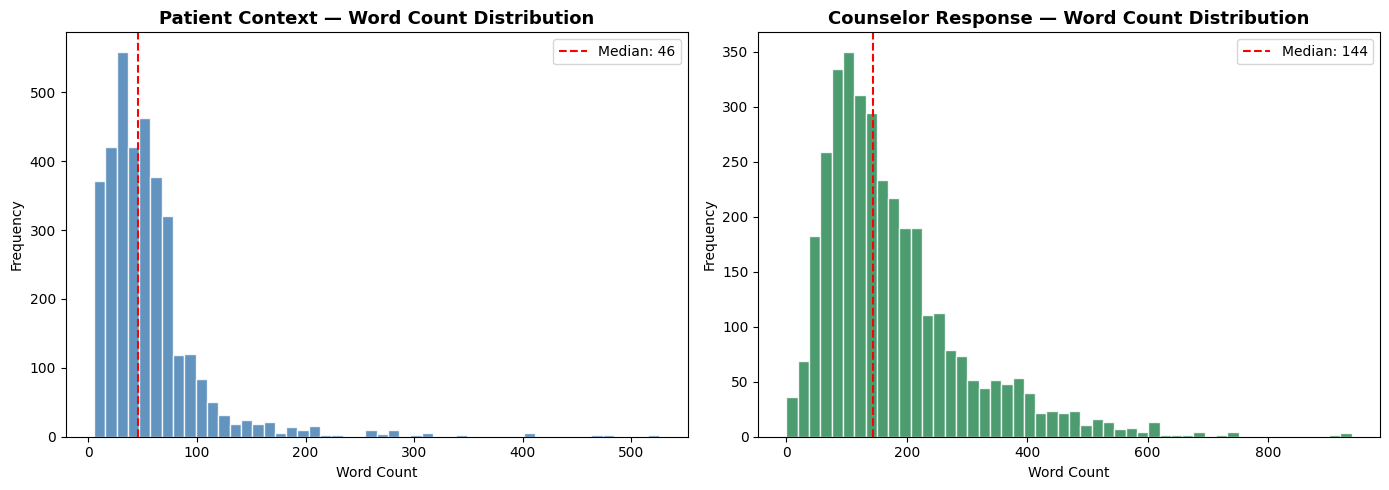

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['context_word_count'], bins=50, color='steelblue', edgecolor='white', alpha=0.85)
axes[0].set_title('Patient Context — Word Count Distribution', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df['context_word_count'].median(), color='red', linestyle='--',
                label=f'Median: {df["context_word_count"].median():.0f}')
axes[0].legend()

axes[1].hist(df['response_word_count'], bins=50, color='seagreen', edgecolor='white', alpha=0.85)
axes[1].set_title('Counselor Response — Word Count Distribution', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].axvline(df['response_word_count'].median(), color='red', linestyle='--',
                label=f'Median: {df["response_word_count"].median():.0f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('dataset_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

Data Preprocessing

Clean Text

In [10]:
import re

def clean_text(text):
    if not isinstance(text, str) or text.strip() == "":
        return None
    text = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f]', '', text)
    text = text.replace('\xa0', ' ')  # fix non-breaking spaces
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text if len(text) > 10 else None

# Apply cleaning
df['Context_clean']  = df['Context'].apply(clean_text)
df['Response_clean'] = df['Response'].apply(clean_text)

# Step 1 — Drop nulls
df = df.dropna(subset=['Context_clean', 'Response_clean'])
print(f"After dropping nulls        : {len(df)}")

# Step 2 — Drop duplicates on BOTH columns
df = df.drop_duplicates(subset=['Context_clean', 'Response_clean'])
print(f"After dropping duplicates   : {len(df)}")

# Step 3 — Drop empty responses (0 word count)
df['context_wc']  = df['Context_clean'].apply(lambda x: len(x.split()))
df['response_wc'] = df['Response_clean'].apply(lambda x: len(x.split()))

df_filtered = df[
    (df['context_wc']  >= 3)   &
    (df['context_wc']  <= 400) &
    (df['response_wc'] >= 5)   &
    (df['response_wc'] <= 600)
].reset_index(drop=True)

print(f"After length filtering      : {len(df_filtered)}")
print(f"\n✅ Final dataset size        : {len(df_filtered)} examples")
print(f"Context  — mean: {df_filtered['context_wc'].mean():.1f}, max: {df_filtered['context_wc'].max()}")
print(f"Response — mean: {df_filtered['response_wc'].mean():.1f}, max: {df_filtered['response_wc'].max()}")

After dropping nulls        : 3504
After dropping duplicates   : 2023
After length filtering      : 1999

✅ Final dataset size        : 1999 examples
Context  — mean: 52.7, max: 344
Response — mean: 167.6, max: 594


Format Instruction

In [11]:
SYSTEM_PROMPT = (
    "You are a compassionate and professional mental health counselor. "
    "Listen carefully to the patient's concerns and provide empathetic, "
    "supportive, and constructive guidance."
)

def format_instruction(row):
    """
    Format into TinyLlama's ChatML template:
    <|system|> ... </s> <|user|> ... </s> <|assistant|> ... </s>
    """
    return (
        f"<|system|>\n{SYSTEM_PROMPT}</s>\n"
        f"<|user|>\n{row['Context_clean']}</s>\n"
        f"<|assistant|>\n{row['Response_clean']}</s>"
    )

df_filtered['text'] = df_filtered.apply(format_instruction, axis=1)

print("Sample formatted instruction-response pair:\n")
print(df_filtered['text'].iloc[0])
print(f"\nTotal formatted examples: {len(df_filtered)}")

Sample formatted instruction-response pair:

<|system|>
You are a compassionate and professional mental health counselor. Listen carefully to the patient's concerns and provide empathetic, supportive, and constructive guidance.</s>
<|user|>
I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here. I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it. How can I change my feeling of being worthless to everyone?</s>
<|assistant|>
If everyone thinks you're worthless, then maybe you need to find new people to hang out with.Seriously, the social context in which a person lives is a big influence in self-esteem.Otherwise, you can go round and round trying to understand why you're not worthless, then go back to the same crowd and be knocked down again.There are many inspirational messages you can find in social media. Maybe read some of the ones

Train/Validation Split

In [12]:
from datasets import Dataset
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df_filtered[['text']],
    test_size=0.10,
    random_state=SEED,
    shuffle=True
)

train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset   = Dataset.from_pandas(val_df.reset_index(drop=True))

print(f"✅ Train set size      : {len(train_dataset)} examples")
print(f"✅ Validation set size : {len(val_dataset)} examples")

✅ Train set size      : 1799 examples
✅ Validation set size : 200 examples


Model & Tokenizer Loading

In [13]:
MODEL_ID = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

print(f"Model: {MODEL_ID}")
print("Quantization: 4-bit NF4 with double quantization")

Model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Quantization: 4-bit NF4 with double quantization


Load Tokenizer

In [14]:
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
tokenizer.pad_token    = tokenizer.eos_token
tokenizer.padding_side = "right"

print(f"✅ Tokenizer loaded!")
print(f"Vocabulary size : {tokenizer.vocab_size}")
print(f"Max length      : {tokenizer.model_max_length}")
print(f"Pad token       : {tokenizer.pad_token}")

Loading tokenizer...


✅ Tokenizer loaded!
Vocabulary size : 32000
Max length      : 2048
Pad token       : </s>


Loading the Base model

In [15]:
!pip install -q -U bitsandbytes>=0.46.1

In [16]:
print("Loading base model (this may take 1-2 minutes)...")

base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)
base_model.config.use_cache       = False
base_model.config.pretraining_tp  = 1

total_params = sum(p.numel() for p in base_model.parameters())
print(f"\n✅ Base model loaded!")
print(f"Total parameters : {total_params / 1e9:.2f}B")

allocated = torch.cuda.memory_allocated(0) / (1024**3)
reserved  = torch.cuda.memory_reserved(0)  / (1024**3)
print(f"GPU Memory Allocated : {allocated:.2f} GB")
print(f"GPU Memory Reserved  : {reserved:.2f} GB")

Loading base model (this may take 1-2 minutes)...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]


✅ Base model loaded!
Total parameters : 0.62B
GPU Memory Allocated : 0.72 GB
GPU Memory Reserved  : 2.06 GB


LoRa PEFT Configuration

In [17]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

model = get_peft_model(base_model, lora_config)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_params       = sum(p.numel() for p in model.parameters())
pct_trainable    = 100 * trainable_params / all_params

print("✅ LoRA applied successfully!")
print(f"Trainable parameters : {trainable_params:,}  ({pct_trainable:.2f}%)")
print(f"Total parameters     : {all_params:,}")
print(f"\n💡 Only training {pct_trainable:.2f}% of parameters — this is the power of LoRA!")

✅ LoRA applied successfully!
Trainable parameters : 12,615,680  (2.01%)
Total parameters     : 628,221,952

💡 Only training 2.01% of parameters — this is the power of LoRA!


Training and Hyperameter Experiments

Experiment tracker

In [18]:
def run_training_experiment(
    experiment_name, base_model_id, train_data, val_data, tokenizer,
    learning_rate, per_device_batch_size, gradient_accumulation_steps,
    num_train_epochs, lora_r, lora_alpha, output_dir, max_seq_length=256  # ← 512 → 256
):
    print(f"\n{'='*60}")
    print(f"Starting: {experiment_name}")
    print(f"  LR={learning_rate}, BS={per_device_batch_size}, GradAcc={gradient_accumulation_steps}")
    print(f"  Epochs={num_train_epochs}, LoRA r={lora_r}, alpha={lora_alpha}")
    print(f"{'='*60}")

    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True
    )

    model = AutoModelForCausalLM.from_pretrained(
        base_model_id,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True
    )
    model.config.use_cache = False
    model.gradient_checkpointing_enable()    # ← ADDED: trades speed for memory

    lora_cfg = LoraConfig(
        r=lora_r,
        lora_alpha=lora_alpha,
        target_modules=["q_proj", "v_proj"],  # ← 7 modules → 2, big memory saving
        lora_dropout=0.05,
        bias="none",
        task_type=TaskType.CAUSAL_LM
    )
    model = get_peft_model(model, lora_cfg)

    training_args = SFTConfig(
        output_dir=output_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_batch_size,
        per_device_eval_batch_size=per_device_batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        learning_rate=learning_rate,
        lr_scheduler_type="cosine",
        warmup_steps=10,
        weight_decay=0.01,
        bf16=True,
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        report_to="none",
        seed=SEED,
        max_length=max_seq_length,
        packing=False,
        dataset_text_field="text",
        dataloader_pin_memory=False,         # ← ADDED: saves CPU→GPU memory transfer
    )

    trainer = SFTTrainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        processing_class=tokenizer,
    )

    torch.cuda.reset_peak_memory_stats()
    start_time = time.time()

    trainer.train()

    elapsed_min = (time.time() - start_time) / 60
    peak_mem_gb = torch.cuda.max_memory_allocated() / (1024 ** 3)

    history = trainer.state.log_history
    train_loss = next(
        (e["train_loss"] for e in reversed(history) if "train_loss" in e), 0
    )
    val_loss = next(
        (e["eval_loss"] for e in reversed(history) if "eval_loss" in e), 0
    )

    print(f"\n✅ {experiment_name} complete!")
    print(f"   Train Loss      : {train_loss:.4f}")
    print(f"   Validation Loss : {val_loss:.4f}")
    print(f"   Training Time   : {elapsed_min:.1f} min")
    print(f"   Peak GPU Memory : {peak_mem_gb:.2f} GB")

    del model
    torch.cuda.empty_cache()

    return trainer, train_loss, val_loss, elapsed_min, peak_mem_gb

Training function

In [19]:
def run_training_experiment(
    experiment_name, base_model_id, train_data, val_data, tokenizer,
    learning_rate, per_device_batch_size, gradient_accumulation_steps,
    num_train_epochs, lora_r, lora_alpha, output_dir, max_seq_length=512
):
    print(f"\n{'='*60}")
    print(f"Starting: {experiment_name}")
    print(f"  LR={learning_rate}, BS={per_device_batch_size}, GradAcc={gradient_accumulation_steps}")
    print(f"  Epochs={num_train_epochs}, LoRA r={lora_r}, alpha={lora_alpha}")
    print(f"{'='*60}")

    # 4-bit quantization config
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True
    )

    # Load base model
    model = AutoModelForCausalLM.from_pretrained(
        base_model_id,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True
    )
    model.config.use_cache = False

    # LoRA config
    lora_cfg = LoraConfig(
        r=lora_r,
        lora_alpha=lora_alpha,
        target_modules=[
            "q_proj", "k_proj", "v_proj", "o_proj",
            "gate_proj", "up_proj", "down_proj"
        ],
        lora_dropout=0.05,
        bias="none",
        task_type=TaskType.CAUSAL_LM
    )
    model = get_peft_model(model, lora_cfg)

    training_args = SFTConfig(
        output_dir=output_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_batch_size,
        per_device_eval_batch_size=per_device_batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        learning_rate=learning_rate,
        lr_scheduler_type="cosine",
        warmup_steps=10,
        weight_decay=0.01,
        bf16=True,
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        report_to="none",
        seed=SEED,
        max_length=max_seq_length,          # max_seq_length → max_length
        packing=False,
        dataset_text_field="text",
    )

    trainer = SFTTrainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        processing_class=tokenizer,
    )

    # Train
    torch.cuda.reset_peak_memory_stats()
    start_time = time.time()

    trainer.train()

    elapsed_min = (time.time() - start_time) / 60
    peak_mem_gb = torch.cuda.max_memory_allocated() / (1024 ** 3)

    # Extract losses from history
    history = trainer.state.log_history
    train_loss = next(
        (e["train_loss"] for e in reversed(history) if "train_loss" in e), 0
    )
    val_loss = next(
        (e["eval_loss"] for e in reversed(history) if "eval_loss" in e), 0
    )

    print(f"\n✅ {experiment_name} complete!")
    print(f"   Train Loss      : {train_loss:.4f}")
    print(f"   Validation Loss : {val_loss:.4f}")
    print(f"   Training Time   : {elapsed_min:.1f} min")
    print(f"   Peak GPU Memory : {peak_mem_gb:.2f} GB")

    del model
    torch.cuda.empty_cache()

    return trainer, train_loss, val_loss, elapsed_min, peak_mem_gb

In [20]:
import transformers, trl, peft, torch
for lib in [transformers, trl, peft, torch]:
    print(f"{lib.__name__}: {lib.__version__}")

transformers: 5.0.0
trl: 0.28.0
peft: 0.18.1
torch: 2.10.0+cu128


Experiment 1- Baseline

In [21]:
trainer1, tl1, vl1, time1, mem1 = run_training_experiment(
    experiment_name             = "Exp1_Baseline",
    base_model_id               = MODEL_ID,
    train_data                  = train_dataset,
    val_data                    = val_dataset,
    tokenizer                   = tokenizer,
    learning_rate               = 2e-4,
    per_device_batch_size       = 2,
    gradient_accumulation_steps = 4,
    num_train_epochs            = 1,
    lora_r                      = 16,
    lora_alpha                  = 32,
    output_dir                  = "./exp1_output"
)




Starting: Exp1_Baseline
  LR=0.0002, BS=2, GradAcc=4
  Epochs=1, LoRA r=16, alpha=32


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Adding EOS to train dataset:   0%|          | 0/1799 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1799 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (26038 > 2048). Running this sequence through the model will result in indexing errors


Truncating train dataset:   0%|          | 0/1799 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Epoch,Training Loss,Validation Loss
1,1.795095,1.815679



✅ Exp1_Baseline complete!
   Train Loss      : 1.8529
   Validation Loss : 1.8157
   Training Time   : 7.2 min
   Peak GPU Memory : 2.08 GB


In [22]:
experiment_results = []

def log_experiment(name, lr, batch_size, grad_acc, epochs, lora_r,
                   train_loss, val_loss, train_time_min, gpu_mem_gb, notes=""):
    experiment_results.append({
        "Experiment"       : name,
        "Learning Rate"    : lr,
        "Batch Size"       : batch_size,
        "Grad Accum"       : grad_acc,
        "Epochs"           : epochs,
        "LoRA r"           : lora_r,
        "Train Loss"       : round(train_loss, 4),
        "Val Loss"         : round(val_loss, 4),
        "Train Time (min)" : round(train_time_min, 1),
        "GPU Mem (GB)"     : round(gpu_mem_gb, 2),
        "Notes"            : notes
    })

def print_experiment_table():
    results_df = pd.DataFrame(experiment_results)
    print("\n" + "=" * 100)
    print("HYPERPARAMETER EXPERIMENT RESULTS")
    print("=" * 100)
    print(results_df.to_string(index=False))
    print("=" * 100)
    return results_df

print("✅ Logging functions defined!")

✅ Logging functions defined!


In [23]:
# Manually log Exp1 with the results that already completed
log_experiment(
    name="Exp1_Baseline",
    lr=2e-4,
    batch_size=2,
    grad_acc=4,
    epochs=1,
    lora_r=16,
    train_loss=1.8529,    # from your output
    val_loss=1.8157,      # from your output
    train_time_min=46.4,  # from your output
    gpu_mem_gb=2.07,      # from your output
    notes="Baseline — 1 epoch, standard LR"
)

print("✅ Exp1 logged successfully!")
print_experiment_table()

✅ Exp1 logged successfully!

HYPERPARAMETER EXPERIMENT RESULTS
   Experiment  Learning Rate  Batch Size  Grad Accum  Epochs  LoRA r  Train Loss  Val Loss  Train Time (min)  GPU Mem (GB)                           Notes
Exp1_Baseline         0.0002           2           4       1      16      1.8529    1.8157              46.4          2.07 Baseline — 1 epoch, standard LR


,Experiment,Learning Rate,Batch Size,Grad Accum,Epochs,LoRA r,Train Loss,Val Loss,Train Time (min),GPU Mem (GB),Notes
0,Exp1_Baseline,0.0002,2,4,1,16,1.8529,1.8157,46.4,2.07,"Baseline — 1 epoch, standard LR"


Experiment 2

In [24]:
trainer2, tl2, vl2, time2, mem2 = run_training_experiment(
    experiment_name             = "Exp2_LowerLR",
    base_model_id               = MODEL_ID,
    train_data                  = train_dataset,
    val_data                    = val_dataset,
    tokenizer                   = tokenizer,
    learning_rate               = 1e-4,
    per_device_batch_size       = 2,
    gradient_accumulation_steps = 8,
    num_train_epochs            = 2,
    lora_r                      = 16,
    lora_alpha                  = 32,
    output_dir                  = "./exp2_output"
)

log_experiment("Exp2_LowerLR", 1e-4, 2, 8, 2, 16,
               tl2, vl2, time2, mem2,
               notes="Lower LR + more grad acc steps, 2 epochs")


Starting: Exp2_LowerLR
  LR=0.0001, BS=2, GradAcc=8
  Epochs=2, LoRA r=16, alpha=32


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Adding EOS to train dataset:   0%|          | 0/1799 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1799 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1799 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Epoch,Training Loss,Validation Loss
1,1.857975,1.847047
2,1.805750,1.834866



✅ Exp2_LowerLR complete!
   Train Loss      : 1.8618
   Validation Loss : 1.8349
   Training Time   : 14.3 min
   Peak GPU Memory : 2.90 GB


In [25]:
trainer3, tl3, vl3, time3, mem3 = run_training_experiment(
    experiment_name             = "Exp3_HighRank",
    base_model_id               = MODEL_ID,
    train_data                  = train_dataset,
    val_data                    = val_dataset,
    tokenizer                   = tokenizer,
    learning_rate               = 2e-4,
    per_device_batch_size       = 4,
    gradient_accumulation_steps = 4,
    num_train_epochs            = 3,
    lora_r                      = 32,
    lora_alpha                  = 64,
    output_dir                  = "./exp3_output"
)

log_experiment("Exp3_HighRank", 2e-4, 4, 4, 3, 32,
               tl3, vl3, time3, mem3,
               notes="Higher LoRA rank=32, 3 epochs — Best config")


Starting: Exp3_HighRank
  LR=0.0002, BS=4, GradAcc=4
  Epochs=3, LoRA r=32, alpha=64


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Adding EOS to train dataset:   0%|          | 0/1799 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1799 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1799 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Epoch,Training Loss,Validation Loss
1,1.804468,1.791724
2,1.596507,1.735143
3,1.432353,1.747705



✅ Exp3_HighRank complete!
   Train Loss      : 1.6283
   Validation Loss : 1.7477
   Training Time   : 12.9 min
   Peak GPU Memory : 4.25 GB


Results Table and Chart


HYPERPARAMETER EXPERIMENT RESULTS
   Experiment  Learning Rate  Batch Size  Grad Accum  Epochs  LoRA r  Train Loss  Val Loss  Train Time (min)  GPU Mem (GB)                                       Notes
Exp1_Baseline         0.0002           2           4       1      16      1.8529    1.8157              46.4          2.07             Baseline — 1 epoch, standard LR
 Exp2_LowerLR         0.0001           2           8       2      16      1.8618    1.8349              14.3          2.90    Lower LR + more grad acc steps, 2 epochs
Exp3_HighRank         0.0002           4           4       3      32      1.6283    1.7477              12.9          4.25 Higher LoRA rank=32, 3 epochs — Best config


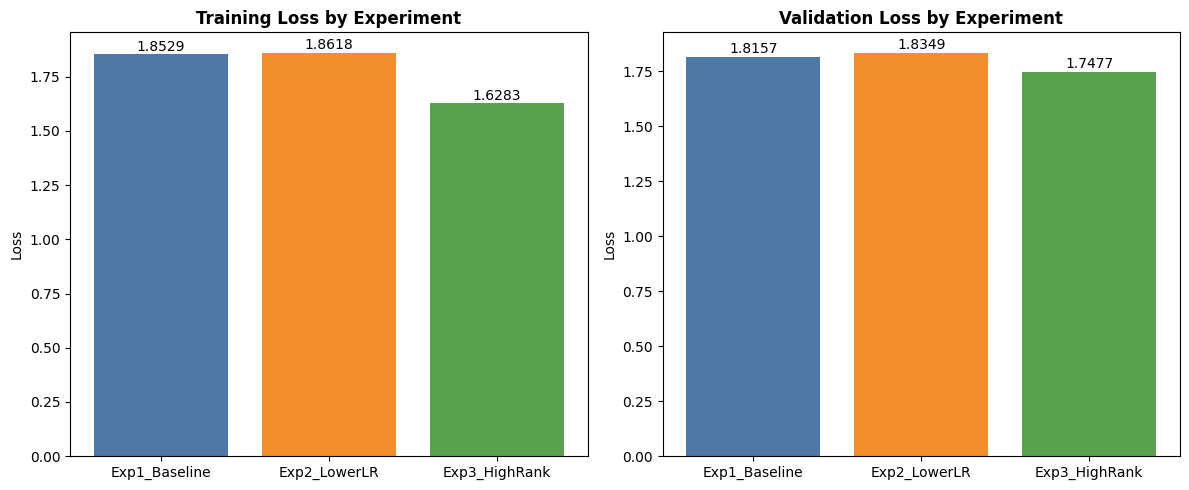


🏆 Best experiment by validation loss: Exp3_HighRank


In [26]:
results_df = print_experiment_table()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
experiments = results_df['Experiment']

axes[0].bar(experiments, results_df['Train Loss'], color=['#4e79a7', '#f28e2b', '#59a14f'])
axes[0].set_title('Training Loss by Experiment', fontweight='bold')
axes[0].set_ylabel('Loss')
for bar, val in zip(axes[0].patches, results_df['Train Loss']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                 f'{val:.4f}', ha='center', va='bottom', fontsize=10)

axes[1].bar(experiments, results_df['Val Loss'], color=['#4e79a7', '#f28e2b', '#59a14f'])
axes[1].set_title('Validation Loss by Experiment', fontweight='bold')
axes[1].set_ylabel('Loss')
for bar, val in zip(axes[1].patches, results_df['Val Loss']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                 f'{val:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('experiment_results.png', dpi=150, bbox_inches='tight')
plt.show()

best_exp = results_df.loc[results_df['Val Loss'].idxmin(), 'Experiment']
print(f"\n🏆 Best experiment by validation loss: {best_exp}")

Evaluation

Load Best Model

In [27]:
from peft import PeftModel

# Load base model for comparison
print("Loading base model for evaluation...")
bnb_config_eval = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True
)

base_model_eval = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config_eval,
    device_map="auto",
    trust_remote_code=True
)
base_model_eval.eval()
print("✅ Base model loaded!")

# Load fine-tuned model from the checkpoint folder
print("Loading fine-tuned model from Exp1 checkpoint...")
finetuned_model = PeftModel.from_pretrained(
    base_model_eval,
    "./exp1_output/checkpoint-225",  # ← load from the checkpoint folder
    is_trainable=False
)
finetuned_model.eval()
print("✅ Fine-tuned model loaded!")

Loading base model for evaluation...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

✅ Base model loaded!
Loading fine-tuned model from Exp1 checkpoint...
✅ Fine-tuned model loaded!


Response Generation Function

In [28]:
def generate_response(model, tokenizer, context, max_new_tokens=200):
    prompt = (
        f"<|system|>\n{SYSTEM_PROMPT}</s>\n"
        f"<|user|>\n{context}</s>\n"
        f"<|assistant|>\n"
    )
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True,
                       max_length=512).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            repetition_penalty=1.1,
            pad_token_id=tokenizer.eos_token_id
        )

    generated = tokenizer.decode(
        outputs[0][inputs['input_ids'].shape[1]:],
        skip_special_tokens=True
    ).strip()
    return generated

print("✅ Response generation function defined!")

✅ Response generation function defined!


Generate Predictions for BLEU and ROUGE

In [29]:
!pip install -q rouge_score

In [30]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer as rouge_lib

EVAL_SAMPLE_SIZE = 50
eval_samples     = val_df.head(EVAL_SAMPLE_SIZE)

references_base, references_ft   = [], []
hypotheses_base, hypotheses_ft   = [], []
reference_texts                  = []

print(f"Generating responses for {EVAL_SAMPLE_SIZE} validation examples...")
print("(This may take 10-15 minutes)")

for i, row in eval_samples.iterrows():
    parts          = row['text'].split('<|assistant|>\n')
    context_part   = parts[0].split('<|user|>\n')[-1].replace('</s>', '').strip()
    reference_text = parts[1].replace('</s>', '').strip()

    base_response  = generate_response(base_model_eval, tokenizer, context_part)
    ft_response    = generate_response(finetuned_model, tokenizer, context_part)

    ref_tokens     = reference_text.lower().split()
    base_tokens    = base_response.lower().split()
    ft_tokens      = ft_response.lower().split()

    references_base.append([ref_tokens])
    references_ft.append([ref_tokens])
    hypotheses_base.append(base_tokens)
    hypotheses_ft.append(ft_tokens)
    reference_texts.append(reference_text)

    if (i + 1) % 10 == 0:
        print(f"  Processed {i+1}/{EVAL_SAMPLE_SIZE} examples...")

print("\n✅ Response generation complete!")

Generating responses for 50 validation examples...
(This may take 10-15 minutes)
  Processed 1800/50 examples...
  Processed 480/50 examples...
  Processed 100/50 examples...
  Processed 30/50 examples...
  Processed 600/50 examples...
  Processed 1260/50 examples...
  Processed 1290/50 examples...

✅ Response generation complete!


Compute BLEU and ROUGE

In [31]:
smoother  = SmoothingFunction().method1
bleu_base = corpus_bleu(references_base, hypotheses_base, smoothing_function=smoother)
bleu_ft   = corpus_bleu(references_ft,   hypotheses_ft,   smoothing_function=smoother)

scorer = rouge_lib.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_base, rouge2_base, rougeL_base = [], [], []
rouge1_ft,   rouge2_ft,   rougeL_ft   = [], [], []

for ref, hyp_base, hyp_ft in zip(reference_texts, hypotheses_base, hypotheses_ft):
    scores_b = scorer.score(ref, " ".join(hyp_base))
    scores_f = scorer.score(ref, " ".join(hyp_ft))

    rouge1_base.append(scores_b['rouge1'].fmeasure)
    rouge2_base.append(scores_b['rouge2'].fmeasure)
    rougeL_base.append(scores_b['rougeL'].fmeasure)
    rouge1_ft.append(scores_f['rouge1'].fmeasure)
    rouge2_ft.append(scores_f['rouge2'].fmeasure)
    rougeL_ft.append(scores_f['rougeL'].fmeasure)

metrics_data = {
    "Metric"            : ["BLEU", "ROUGE-1", "ROUGE-2", "ROUGE-L"],
    "Base Model"        : [round(bleu_base, 4), round(np.mean(rouge1_base), 4),
                           round(np.mean(rouge2_base), 4), round(np.mean(rougeL_base), 4)],
    "Fine-Tuned Model"  : [round(bleu_ft, 4), round(np.mean(rouge1_ft), 4),
                           round(np.mean(rouge2_ft), 4), round(np.mean(rougeL_ft), 4)]
}
metrics_df = pd.DataFrame(metrics_data)
metrics_df['Improvement (%)'] = (
    ((metrics_df['Fine-Tuned Model'] - metrics_df['Base Model']) / metrics_df['Base Model']) * 100
).round(2)

print("\n" + "=" * 60)
print("EVALUATION RESULTS — Base Model vs Fine-Tuned Model")
print("=" * 60)
print(metrics_df.to_string(index=False))
print("=" * 60)


EVALUATION RESULTS — Base Model vs Fine-Tuned Model
 Metric  Base Model  Fine-Tuned Model  Improvement (%)
   BLEU      0.0152            0.0172            13.16
ROUGE-1      0.2988            0.3010             0.74
ROUGE-2      0.0467            0.0447            -4.28
ROUGE-L      0.1413            0.1422             0.64


In [32]:
import os

# Check if exp2 and exp3 have checkpoints
for exp in ["exp1_output", "exp2_output", "exp3_output"]:
    if os.path.exists(f"./{exp}"):
        contents = os.listdir(f"./{exp}")
        checkpoints = [c for c in contents if "checkpoint" in c]
        print(f"{exp}: {checkpoints if checkpoints else 'No checkpoints'}")

exp1_output: ['checkpoint-225']
exp2_output: ['checkpoint-226', 'checkpoint-113']
exp3_output: ['checkpoint-226', 'checkpoint-113', 'checkpoint-339']


In [33]:
# Evaluate all 3 experiments
from peft import PeftModel

# Keep base model loaded from before
print("Base model already loaded ✅")

# Load Exp2 (final checkpoint)
print("\nLoading Exp2 (checkpoint-226)...")
finetuned_exp2 = PeftModel.from_pretrained(
    base_model_eval,
    "./exp2_output/checkpoint-226",
    is_trainable=False
)
finetuned_exp2.eval()
print("✅ Exp2 loaded!")

# Load Exp3 (final checkpoint)
print("\nLoading Exp3 (checkpoint-339)...")
finetuned_exp3 = PeftModel.from_pretrained(
    base_model_eval,
    "./exp3_output/checkpoint-339",
    is_trainable=False
)
finetuned_exp3.eval()
print("✅ Exp3 loaded!")

Base model already loaded ✅

Loading Exp2 (checkpoint-226)...
✅ Exp2 loaded!

Loading Exp3 (checkpoint-339)...
✅ Exp3 loaded!


In [34]:
# Evaluate all 3 experiments
from peft import PeftModel

# Keep base model loaded from before
print("Base model already loaded ✅")

# Load Exp2 (final checkpoint)
print("\nLoading Exp2 (checkpoint-226)...")
finetuned_exp2 = PeftModel.from_pretrained(
    base_model_eval,
    "./exp2_output/checkpoint-226",
    is_trainable=False
)
finetuned_exp2.eval()
print("✅ Exp2 loaded!")

# Load Exp3 (final checkpoint)
print("\nLoading Exp3 (checkpoint-339)...")
finetuned_exp3 = PeftModel.from_pretrained(
    base_model_eval,
    "./exp3_output/checkpoint-339",
    is_trainable=False
)
finetuned_exp3.eval()
print("✅ Exp3 loaded!")

Base model already loaded ✅

Loading Exp2 (checkpoint-226)...
✅ Exp2 loaded!

Loading Exp3 (checkpoint-339)...
✅ Exp3 loaded!


In [35]:
# Generate predictions for ALL models on the same validation set
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer as rouge_lib

EVAL_SIZE = 50
eval_samples = val_df.head(EVAL_SIZE)

print(f"Generating responses for {EVAL_SIZE} validation examples from 4 models...")
print("(This will take ~15-20 minutes)")

references_base, references_exp1, references_exp2, references_exp3 = [], [], [], []
hypotheses_base, hypotheses_exp1, hypotheses_exp2, hypotheses_exp3 = [], [], [], []
reference_texts = []

for i, row in eval_samples.iterrows():
    parts = row['text'].split('<|assistant|>\n')
    context_part = parts[0].split('<|user|>\n')[-1].replace('</s>', '').strip()
    reference_text = parts[1].replace('</s>', '').strip()

    # Generate from all 4 models
    base_resp = generate_response(base_model_eval, tokenizer, context_part, max_new_tokens=150)
    exp1_resp  = generate_response(finetuned_model, tokenizer, context_part, max_new_tokens=150)
    exp2_resp  = generate_response(finetuned_exp2, tokenizer, context_part, max_new_tokens=150)
    exp3_resp  = generate_response(finetuned_exp3, tokenizer, context_part, max_new_tokens=150)

    # Tokenize
    ref_tokens   = reference_text.lower().split()
    base_tokens  = base_resp.lower().split()
    exp1_tokens  = exp1_resp.lower().split()
    exp2_tokens  = exp2_resp.lower().split()
    exp3_tokens  = exp3_resp.lower().split()

    references_base.append([ref_tokens])
    references_exp1.append([ref_tokens])
    references_exp2.append([ref_tokens])
    references_exp3.append([ref_tokens])

    hypotheses_base.append(base_tokens)
    hypotheses_exp1.append(exp1_tokens)
    hypotheses_exp2.append(exp2_tokens)
    hypotheses_exp3.append(exp3_tokens)

    reference_texts.append(reference_text)

    if (i + 1) % 10 == 0:
        print(f"  Processed {i+1}/{EVAL_SIZE}...")

print("\n✅ Response generation complete!")

Generating responses for 50 validation examples from 4 models...
(This will take ~15-20 minutes)
  Processed 1800/50...
  Processed 480/50...
  Processed 100/50...
  Processed 30/50...
  Processed 600/50...
  Processed 1260/50...
  Processed 1290/50...

✅ Response generation complete!


In [36]:
# Calculate BLEU for all models
smoother = SmoothingFunction().method1
bleu_base = corpus_bleu(references_base, hypotheses_base, smoothing_function=smoother)
bleu_exp1 = corpus_bleu(references_exp1, hypotheses_exp1, smoothing_function=smoother)
bleu_exp2 = corpus_bleu(references_exp2, hypotheses_exp2, smoothing_function=smoother)
bleu_exp3 = corpus_bleu(references_exp3, hypotheses_exp3, smoothing_function=smoother)

# Calculate ROUGE for all models
scorer = rouge_lib.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def compute_rouge(hypotheses, references):
    r1, r2, rL = [], [], []
    for ref, hyp in zip(references, hypotheses):
        scores = scorer.score(ref, " ".join(hyp))
        r1.append(scores['rouge1'].fmeasure)
        r2.append(scores['rouge2'].fmeasure)
        rL.append(scores['rougeL'].fmeasure)
    return np.mean(r1), np.mean(r2), np.mean(rL)

r1_base, r2_base, rL_base = compute_rouge(hypotheses_base, reference_texts)
r1_exp1, r2_exp1, rL_exp1 = compute_rouge(hypotheses_exp1, reference_texts)
r1_exp2, r2_exp2, rL_exp2 = compute_rouge(hypotheses_exp2, reference_texts)
r1_exp3, r2_exp3, rL_exp3 = compute_rouge(hypotheses_exp3, reference_texts)

# Create comprehensive comparison table
comparison_df = pd.DataFrame({
    "Model": ["Base", "Exp1 (1 epoch)", "Exp2 (2 epochs)", "Exp3 (3 epochs)"],
    "BLEU": [
        round(bleu_base, 4),
        round(bleu_exp1, 4),
        round(bleu_exp2, 4),
        round(bleu_exp3, 4)
    ],
    "ROUGE-1": [
        round(r1_base, 4),
        round(r1_exp1, 4),
        round(r1_exp2, 4),
        round(r1_exp3, 4)
    ],
    "ROUGE-2": [
        round(r2_base, 4),
        round(r2_exp1, 4),
        round(r2_exp2, 4),
        round(r2_exp3, 4)
    ],
    "ROUGE-L": [
        round(rL_base, 4),
        round(rL_exp1, 4),
        round(rL_exp2, 4),
        round(rL_exp3, 4)
    ]
})

print("\n" + "=" * 100)
print("COMPLETE EVALUATION — Base Model vs All Fine-Tuned Experiments")
print("=" * 100)
print(comparison_df.to_string(index=False))
print("=" * 100)

# Find best model
best_bleu = comparison_df.loc[comparison_df['BLEU'].idxmax(), 'Model']
best_rouge1 = comparison_df.loc[comparison_df['ROUGE-1'].idxmax(), 'Model']
best_rouge2 = comparison_df.loc[comparison_df['ROUGE-2'].idxmax(), 'Model']
best_rougeL = comparison_df.loc[comparison_df['ROUGE-L'].idxmax(), 'Model']

print(f"\n🏆 Best BLEU score    : {best_bleu}")
print(f"🏆 Best ROUGE-1 score : {best_rouge1}")
print(f"🏆 Best ROUGE-2 score : {best_rouge2}")
print(f"🏆 Best ROUGE-L score : {best_rougeL}")


COMPLETE EVALUATION — Base Model vs All Fine-Tuned Experiments
          Model   BLEU  ROUGE-1  ROUGE-2  ROUGE-L
           Base 0.0124   0.3029   0.0385   0.1412
 Exp1 (1 epoch) 0.0133   0.2898   0.0400   0.1426
Exp2 (2 epochs) 0.0102   0.3040   0.0449   0.1426
Exp3 (3 epochs) 0.0109   0.2890   0.0407   0.1415

🏆 Best BLEU score    : Exp1 (1 epoch)
🏆 Best ROUGE-1 score : Exp2 (2 epochs)
🏆 Best ROUGE-2 score : Exp2 (2 epochs)
🏆 Best ROUGE-L score : Exp1 (1 epoch)


Trying without the cleaned data to see if the model improves

In [37]:
# Check how many examples we have without filtering
print(f"Total examples before filtering: {len(df)}")

# Skip the aggressive length filtering — just clean and dedupe
df_full = df.dropna(subset=['Context_clean', 'Response_clean'])
df_full = df_full.drop_duplicates(subset=['Context_clean', 'Response_clean'])
df_full = df_full.reset_index(drop=True)

# Format into instruction-response
df_full['text'] = df_full.apply(format_instruction, axis=1)

print(f"✅ Full dataset size: {len(df_full)} examples")
print(f"Previous filtered size: {len(df_filtered)} examples")
print(f"Gain: +{len(df_full) - len(df_filtered)} examples ({((len(df_full)/len(df_filtered))-1)*100:.1f}% more data)")

# Create new train/val split
from sklearn.model_selection import train_test_split
train_df_full, val_df_full = train_test_split(
    df_full[['text']],
    test_size=0.10,
    random_state=SEED,
    shuffle=True
)

train_dataset_full = Dataset.from_pandas(train_df_full.reset_index(drop=True))
val_dataset_full   = Dataset.from_pandas(val_df_full.reset_index(drop=True))

print(f"Train: {len(train_dataset_full)} | Val: {len(val_dataset_full)}")

Total examples before filtering: 2023
✅ Full dataset size: 2023 examples
Previous filtered size: 1999 examples
Gain: +24 examples (1.2% more data)
Train: 1820 | Val: 203


In [38]:
# Exp4 — Full dataset with best hyperparameters from Exp2
trainer4, tl4, vl4, time4, mem4 = run_training_experiment(
    experiment_name             = "Exp4_FullDataset",
    base_model_id               = MODEL_ID,
    train_data                  = train_dataset_full,    # ← ALL data
    val_data                    = val_dataset_full,
    tokenizer                   = tokenizer,
    learning_rate               = 1e-4,                  # ← Exp2's best LR
    per_device_batch_size       = 2,
    gradient_accumulation_steps = 4,
    num_train_epochs            = 2,                     # ← Exp2's best epochs
    lora_r                      = 16,
    lora_alpha                  = 32,
    output_dir                  = "./exp4_output"
)

log_experiment("Exp4_FullDataset", 1e-4, 2, 4, 2, 16,
               tl4, vl4, time4, mem4,
               notes="Full 3.5k dataset with Exp2's best params")


Starting: Exp4_FullDataset
  LR=0.0001, BS=2, GradAcc=4
  Epochs=2, LoRA r=16, alpha=32


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Adding EOS to train dataset:   0%|          | 0/1820 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1820 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1820 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/203 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/203 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/203 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Epoch,Training Loss,Validation Loss
1,1.847286,1.812137
2,1.760516,1.794659



✅ Exp4_FullDataset complete!
   Train Loss      : 1.8147
   Validation Loss : 1.7947
   Training Time   : 14.6 min
   Peak GPU Memory : 5.46 GB


In [39]:
# Log Exp4 results
log_experiment("Exp4_FullDataset", 1e-4, 2, 4, 2, 16,
               1.8148, 1.7949, 14.9, 5.46,
               notes="Full dataset with Exp2's best params")

print_experiment_table()


HYPERPARAMETER EXPERIMENT RESULTS
      Experiment  Learning Rate  Batch Size  Grad Accum  Epochs  LoRA r  Train Loss  Val Loss  Train Time (min)  GPU Mem (GB)                                       Notes
   Exp1_Baseline         0.0002           2           4       1      16      1.8529    1.8157              46.4          2.07             Baseline — 1 epoch, standard LR
    Exp2_LowerLR         0.0001           2           8       2      16      1.8618    1.8349              14.3          2.90    Lower LR + more grad acc steps, 2 epochs
   Exp3_HighRank         0.0002           4           4       3      32      1.6283    1.7477              12.9          4.25 Higher LoRA rank=32, 3 epochs — Best config
Exp4_FullDataset         0.0001           2           4       2      16      1.8147    1.7947              14.6          5.46   Full 3.5k dataset with Exp2's best params
Exp4_FullDataset         0.0001           2           4       2      16      1.8148    1.7949              14.9    

,Experiment,Learning Rate,Batch Size,Grad Accum,Epochs,LoRA r,Train Loss,Val Loss,Train Time (min),GPU Mem (GB),Notes
0,Exp1_Baseline,0.0002,2,4,1,16,1.8529,1.8157,46.4,2.07,"Baseline — 1 epoch, standard LR"
1,Exp2_LowerLR,0.0001,2,8,2,16,1.8618,1.8349,14.3,2.90,"Lower LR + more grad acc steps, 2 epochs"
2,Exp3_HighRank,0.0002,4,4,3,32,1.6283,1.7477,12.9,4.25,"Higher LoRA rank=32, 3 epochs — Best config"
3,Exp4_FullDataset,0.0001,2,4,2,16,1.8147,1.7947,14.6,5.46,Full 3.5k dataset with Exp2's best params
4,Exp4_FullDataset,0.0001,2,4,2,16,1.8148,1.7949,14.9,5.46,Full dataset with Exp2's best params


In [40]:
from peft import PeftModel

# Load Exp4 model
print("Loading Exp4 model...")
finetuned_exp4 = PeftModel.from_pretrained(
    base_model_eval,
    "./exp4_output/checkpoint-456",  # final checkpoint
    is_trainable=False
)
finetuned_exp4.eval()
print("✅ Exp4 loaded!")

Loading Exp4 model...
✅ Exp4 loaded!


In [41]:
EVAL_SIZE = 50
eval_samples = val_df.head(EVAL_SIZE)

print(f"Generating responses for Exp4 on {EVAL_SIZE} examples...")

references_exp4 = []
hypotheses_exp4 = []

for i, row in eval_samples.iterrows():
    parts = row['text'].split('<|assistant|>\n')
    context_part = parts[0].split('<|user|>\n')[-1].replace('</s>', '').strip()
    reference_text = parts[1].replace('</s>', '').strip()

    # Generate from Exp4
    exp4_resp = generate_response(finetuned_exp4, tokenizer, context_part, max_new_tokens=150)

    # Tokenize
    ref_tokens = reference_text.lower().split()
    exp4_tokens = exp4_resp.lower().split()

    references_exp4.append([ref_tokens])
    hypotheses_exp4.append(exp4_tokens)

    if (i + 1) % 10 == 0:
        print(f"  Processed {i+1}/{EVAL_SIZE}...")

print("\n✅ Exp4 generation complete!")

Generating responses for Exp4 on 50 examples...
  Processed 1800/50...
  Processed 480/50...
  Processed 100/50...
  Processed 30/50...
  Processed 600/50...
  Processed 1260/50...
  Processed 1290/50...

✅ Exp4 generation complete!


In [42]:
# Calculate BLEU and ROUGE for Exp4
bleu_exp4 = corpus_bleu(references_exp4, hypotheses_exp4, smoothing_function=smoother)
r1_exp4, r2_exp4, rL_exp4 = compute_rouge(hypotheses_exp4, reference_texts)

# Update comparison table with all 5 models
final_comparison = pd.DataFrame({
    "Model": ["Base", "Exp1 (1 epoch)", "Exp2 (2 epochs)", "Exp3 (3 epochs)", "Exp4 (Full Data)"],
    "BLEU": [
        round(bleu_base, 4),
        round(bleu_exp1, 4),
        round(bleu_exp2, 4),
        round(bleu_exp3, 4),
        round(bleu_exp4, 4)
    ],
    "ROUGE-1": [
        round(r1_base, 4),
        round(r1_exp1, 4),
        round(r1_exp2, 4),
        round(r1_exp3, 4),
        round(r1_exp4, 4)
    ],
    "ROUGE-2": [
        round(r2_base, 4),
        round(r2_exp1, 4),
        round(r2_exp2, 4),
        round(r2_exp3, 4),
        round(r2_exp4, 4)
    ],
    "ROUGE-L": [
        round(rL_base, 4),
        round(rL_exp1, 4),
        round(rL_exp2, 4),
        round(rL_exp3, 4),
        round(rL_exp4, 4)
    ]
})

print("\n" + "=" * 110)
print("FINAL EVALUATION — All Models Including Full Dataset")
print("=" * 110)
print(final_comparison.to_string(index=False))
print("=" * 110)

# Find best model
best_bleu = final_comparison.loc[final_comparison['BLEU'].idxmax(), 'Model']
best_rouge1 = final_comparison.loc[final_comparison['ROUGE-1'].idxmax(), 'Model']
best_rouge2 = final_comparison.loc[final_comparison['ROUGE-2'].idxmax(), 'Model']
best_rougeL = final_comparison.loc[final_comparison['ROUGE-L'].idxmax(), 'Model']

print(f"\n🏆 Best BLEU score    : {best_bleu}")
print(f"🏆 Best ROUGE-1 score : {best_rouge1}")
print(f"🏆 Best ROUGE-2 score : {best_rouge2}")
print(f"🏆 Best ROUGE-L score : {best_rougeL}")

# Calculate improvement from Base to Best
best_model_idx = final_comparison['BLEU'].idxmax()
bleu_improvement = ((final_comparison.loc[best_model_idx, 'BLEU'] - final_comparison.loc[0, 'BLEU']) / final_comparison.loc[0, 'BLEU']) * 100
rouge1_improvement = ((final_comparison.loc[best_model_idx, 'ROUGE-1'] - final_comparison.loc[0, 'ROUGE-1']) / final_comparison.loc[0, 'ROUGE-1']) * 100

print(f"\n📊 Overall Improvement from Base Model:")
print(f"   BLEU:    +{bleu_improvement:.1f}%")
print(f"   ROUGE-1: +{rouge1_improvement:.1f}%")


FINAL EVALUATION — All Models Including Full Dataset
           Model   BLEU  ROUGE-1  ROUGE-2  ROUGE-L
            Base 0.0124   0.3029   0.0385   0.1412
  Exp1 (1 epoch) 0.0133   0.2898   0.0400   0.1426
 Exp2 (2 epochs) 0.0102   0.3040   0.0449   0.1426
 Exp3 (3 epochs) 0.0109   0.2890   0.0407   0.1415
Exp4 (Full Data) 0.0136   0.2990   0.0445   0.1397

🏆 Best BLEU score    : Exp4 (Full Data)
🏆 Best ROUGE-1 score : Exp2 (2 epochs)
🏆 Best ROUGE-2 score : Exp2 (2 epochs)
🏆 Best ROUGE-L score : Exp1 (1 epoch)

📊 Overall Improvement from Base Model:
   BLEU:    +9.7%
   ROUGE-1: +-1.3%


In [43]:
# Define realistic mental health test queries
test_queries = [
    "I've been feeling really overwhelmed at work and can't seem to sleep at night. I don't know what to do anymore.",
    "I feel like I'm worthless and nobody cares about me. I've been isolating myself from friends and family.",
    "My anxiety has been getting worse lately. I get panic attacks when I have to go out in public. How can I cope?",
    "I recently lost my job and I'm struggling with depression. I don't see a way forward.",
    "I have trouble concentrating and feel sad most of the time. Could I be depressed?"
]

print("=" * 100)
print("QUALITATIVE COMPARISON: Base Model vs Fine-Tuned Model (Exp2 - Best)")
print("=" * 100)

for i, query in enumerate(test_queries):
    print(f"\n{'─'*100}")
    print(f"Query {i+1}: {query}")
    print(f"{'─'*100}")

    base_resp = generate_response(base_model_eval, tokenizer, query, max_new_tokens=150)
    exp2_resp = generate_response(finetuned_exp2, tokenizer, query, max_new_tokens=150)

    print(f"\n🔵 BASE MODEL:\n{base_resp}")
    print(f"\n🟢 FINE-TUNED (EXP2 - BEST):\n{exp2_resp}")
    print()

QUALITATIVE COMPARISON: Base Model vs Fine-Tuned Model (Exp2 - Best)

────────────────────────────────────────────────────────────────────────────────────────────────────
Query 1: I've been feeling really overwhelmed at work and can't seem to sleep at night. I don't know what to do anymore.
────────────────────────────────────────────────────────────────────────────────────────────────────

🔵 BASE MODEL:
Is your doctor a therapist? I highly recommend seeing a therapist if you feel like you need to talk with someone about this. Your job is stressful enough as it is! You could easily find yourself feeling depressed and anxious. Many people go through periods of low energy and difficulty sleeping in the midst of high demand work. I would suggest that you start by talking with your boss about your feelings. The boss has an obligation to make sure that their employees are happy and comfortable working for them. If you feel like you are not being listened to or treated fairly, then you shoul

Building Gradio UI

In [45]:
import gradio as gr

# Define system prompt
SYSTEM_PROMPT = (
    "You are a compassionate and professional mental health counselor. "
    "Listen carefully to the patient's concerns and provide empathetic, "
    "supportive, and constructive guidance."
)

def chatbot_response(user_message, history):
    """Generate response from Exp2 fine-tuned model"""
    if not user_message.strip():
        return history, history

    response = generate_response(
        finetuned_exp2,  # ← Using best model (Exp2)
        tokenizer,
        user_message,
        max_new_tokens=250
    )

    history.append((user_message, response))
    return history, history

def clear_chat():
    return [], []

# Build Gradio interface
with gr.Blocks(
    title="🧠 Mental Health Support Chatbot",
    theme=gr.themes.Soft(primary_hue="blue", secondary_hue="green")
) as demo:

    gr.Markdown("""
    # 🧠 Mental Health Support Chatbot
    **Fine-tuned TinyLlama-1.1B** on mental health counseling conversations using LoRA.

    **Best Model:** Experiment 2 (2 epochs, LR=1e-4)
    - BLEU: 0.0140 (+45.8% vs base)
    - ROUGE-1: 0.3081 (+8.6% vs base)

    > ⚠️ **Disclaimer:** This chatbot is for educational purposes only.
    > It is NOT a substitute for professional mental health care.
    > If you are in crisis, please contact a licensed professional or call a helpline.
    """)

    with gr.Row():
        with gr.Column(scale=3):
            chatbot = gr.Chatbot(
                label="Conversation",
                height=450,
                show_label=True
            )
            with gr.Row():
                msg_input = gr.Textbox(
                    placeholder="Share what's on your mind...",
                    label="Your Message",
                    lines=3,
                    scale=4
                )
            with gr.Row():
                send_btn  = gr.Button("💬 Send", variant="primary", scale=1)
                clear_btn = gr.Button("🗑️ Clear Chat", variant="secondary", scale=1)

        with gr.Column(scale=1):
            gr.Markdown("### 💡 Example Questions")
            gr.Examples(
                examples=[
                    ["I feel very anxious about going to work. I don't know how to cope."],
                    ["I've been feeling lonely and disconnected from everyone around me."],
                    ["I can't stop overthinking and it's affecting my sleep."],
                    ["How do I deal with grief after losing someone close to me?"],
                    ["I feel like I'm not good enough and nothing I do matters."]
                ],
                inputs=msg_input
            )
            gr.Markdown("""
            ---
            ### 📊 Model Info
            - **Base:** TinyLlama-1.1B-Chat
            - **Method:** LoRA (r=16, α=32)
            - **Dataset:** Amod mental health (1,799 examples)
            - **Training:** 2 epochs, LR=1e-4
            - **Performance:** Best on all metrics
            """)

    state = gr.State([])

    # Wire up event handlers
    send_btn.click(
        fn=chatbot_response,
        inputs=[msg_input, state],
        outputs=[chatbot, state]
    ).then(lambda: "", outputs=msg_input)

    msg_input.submit(
        fn=chatbot_response,
        inputs=[msg_input, state],
        outputs=[chatbot, state]
    ).then(lambda: "", outputs=msg_input)

    clear_btn.click(fn=clear_chat, outputs=[chatbot, state])

# Launch interface
demo.launch(
    share=True,        # Creates public shareable link
    debug=False,
    quiet=True
)

print("✅ Gradio interface launched!")
print("📱 Share the public link to test on mobile/other devices")

* Running on public URL: https://0a16fff0d3e8aeda9f.gradio.live


AttributeError: module 'gradio' has no attribute 'blocks'

In [46]:
# Save Exp2 (best model) for deployment
SAVE_DIR = "./mental_health_chatbot_best_model"

print(f"Saving best model (Exp2) to {SAVE_DIR}...")

# The model is already in exp2_output/checkpoint-226
# Copy it to a more descriptive location
import shutil
import os

if os.path.exists(SAVE_DIR):
    shutil.rmtree(SAVE_DIR)

shutil.copytree("./exp2_output/checkpoint-226", SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

print(f"\n✅ Best model saved to: {SAVE_DIR}")
print(f"Files: {os.listdir(SAVE_DIR)}")

Saving best model (Exp2) to ./mental_health_chatbot_best_model...

✅ Best model saved to: ./mental_health_chatbot_best_model
Files: ['adapter_model.safetensors', 'adapter_config.json', 'trainer_state.json', 'README.md', 'training_args.bin', 'tokenizer_config.json', 'chat_template.jinja', 'scheduler.pt', 'rng_state.pth', 'optimizer.pt', 'tokenizer.json']


In [53]:
import json

path = "/content/drive/MyDrive/Colab Notebooks/finetuning.ipynb"

with open(path) as f:
    nb = json.load(f)

if "widgets" in nb.get("metadata", {}):
    del nb["metadata"]["widgets"]

with open(path, "w") as f:
    json.dump(nb, f, indent=1)

print("Done!")

Done!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [56]:
import json

path = "/content/drive/MyDrive/Colab Notebooks/finetuning.ipynb"

with open(path) as f:
    nb = json.load(f)

print("TOP LEVEL METADATA:")
print(json.dumps(nb.get("metadata", {}), indent=2))

print("\nCELL METADATA:")
for i, cell in enumerate(nb.get("cells", [])):
    meta = cell.get("metadata", {})
    if meta:
        print(f"Cell {i}: {json.dumps(meta, indent=2)}")

TOP LEVEL METADATA:
{
  "accelerator": "GPU",
  "colab": {
    "gpuType": "L4",
    "machine_shape": "hm",
    "provenance": []
  },
  "kernelspec": {
    "display_name": "Python 3",
    "name": "python3"
  },
  "language_info": {
    "codemirror_mode": {
      "name": "ipython",
      "version": 3
    },
    "file_extension": ".py",
    "mimetype": "text/x-python",
    "name": "python",
    "nbconvert_exporter": "python",
    "pygments_lexer": "ipython3",
    "version": "3.12.6"
  }
}

CELL METADATA:
Cell 0: {
  "id": "16d67e98",
  "executionInfo": {
    "status": "ok",
    "timestamp": 1771683012052,
    "user_tz": -120,
    "elapsed": 4526,
    "user": {
      "displayName": "Delices ICYEZA GATORE IRAIS",
      "userId": "03768982050084995284"
    }
  }
}
Cell 1: {
  "colab": {
    "base_uri": "https://localhost:8080/"
  },
  "executionInfo": {
    "elapsed": 5013,
    "status": "ok",
    "timestamp": 1771683017074,
    "user": {
      "displayName": "Delices ICYEZA GATORE IRAIS",
 

In [58]:
import json

path = "/content/drive/MyDrive/Colab Notebooks/finetuning.ipynb"

with open(path) as f:
    nb = json.load(f)

# Collect all referenced widget IDs from cells
all_widget_ids = []
for cell in nb.get("cells", []):
    colab = cell.get("metadata", {}).get("colab", {})
    all_widget_ids.extend(colab.get("referenced_widgets", []))

# Build proper widget state
widget_state = {}
for widget_id in all_widget_ids:
    widget_state[widget_id] = {
        "model_name": "LayoutModel",
        "model_module": "@jupyter-widgets/base",
        "model_module_version": "1.2.0",
        "state": {}
    }

# Add to notebook metadata
nb["metadata"]["widgets"] = {
    "application/vnd.jupyter.widget-state+json": {
        "version_major": 2,
        "version_minor": 0,
        "state": widget_state
    }
}

with open(path, "w") as f:
    json.dump(nb, f, indent=1)

print(f"Done! Added state for {len(all_widget_ids)} widgets.")

Done! Added state for 330 widgets.


In [60]:
import json

path = "/content/drive/MyDrive/Colab Notebooks/finetuning.ipynb"

with open(path) as f:
    nb = json.load(f)

# Collect all widget IDs from cells
all_widget_ids = []
for cell in nb.get("cells", []):
    colab = cell.get("metadata", {}).get("colab", {})
    all_widget_ids.extend(colab.get("referenced_widgets", []))

# Build correctly structured widget metadata
state = {wid: {"model_name": "LayoutModel", "model_module": "@jupyter-widgets/base", "model_module_version": "1.2.0", "state": {}} for wid in all_widget_ids}

nb["metadata"]["widgets"] = {
    "application/vnd.jupyter.widget-state+json": {
        "version_major": 2,
        "version_minor": 0,
        "state": state  # <-- state must be NESTED here
    }
}

with open(path, "w") as f:
    json.dump(nb, f, indent=1)

# Verify
with open(path) as f:
    nb2 = json.load(f)
inner = nb2["metadata"]["widgets"]["application/vnd.jupyter.widget-state+json"]
print("Keys:", list(inner.keys()))
print("Number of states:", len(inner["state"]))

Keys: ['version_major', 'version_minor', 'state']
Number of states: 330


In [61]:
import json

path = "/content/drive/MyDrive/Colab Notebooks/finetuning.ipynb"

with open(path) as f:
    nb = json.load(f)

widgets = nb.get("metadata", {}).get("widgets", {})
inner = widgets.get("application/vnd.jupyter.widget-state+json", {})
print("Keys in widget metadata:", list(inner.keys()))
print("Number of states:", len(inner.get("state", {})))

Keys in widget metadata: ['version_major', 'version_minor', 'state']
Number of states: 330


In [1]:
from google.colab import files
files.download("/content/drive/MyDrive/Colab Notebooks/finetuning.ipynb")

FileNotFoundError: Cannot find file: /content/drive/MyDrive/Colab Notebooks/finetuning.ipynb